In [ ]:
!pip install deap


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from deap import base, creator, tools, algorithms
import random
import warnings
from sklearn.ensemble import RandomForestClassifier
 # Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from scipy import stats
from sklearn.feature_selection import mutual_info_classif
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from google.colab import drive

warnings.filterwarnings("ignore")


In [ ]:

df = pd.read_csv('/content/AmesHousing.csv')


print("Shape:", df.shape)
print(df.dtypes.value_counts())
df.head()



Shape: (2930, 82)
object     43
int64      28
float64    11
Name: count, dtype: int64


,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [ ]:
# total null elements

df.isnull().sum()[df.isnull().sum() > 0]

,0
Lot Frontage,490
Alley,2732
Mas Vnr Type,1775
Mas Vnr Area,23
Bsmt Qual,80
Bsmt Cond,80
Bsmt Exposure,83
BsmtFin Type 1,80
BsmtFin SF 1,1
BsmtFin Type 2,81


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = df.drop('PID',axis=1)


missing_percentage = df.isnull().mean() * 100

# Drop columns with >50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
df = df.drop(columns=columns_to_drop)

print(f"Dropped columns with >50% missing values: {list(columns_to_drop)}")

for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].mean(), inplace=True)

categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

Dropped columns with >50% missing values: ['Alley', 'Mas Vnr Type', 'Pool QC', 'Fence', 'Misc Feature']


In [ ]:

print("Shape:", df.shape)
print(df.dtypes.value_counts())
df.head()



Shape: (2930, 76)
int64      65
float64    11
Name: count, dtype: int64


,Order,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Lot Shape,Land Contour,Utilities,Lot Config,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,20,5,141.0,31770,1,0,3,0,0,...,0,0,0,0,0,5,2010,9,4,215000
1,2,20,4,80.0,11622,1,3,3,0,4,...,0,0,120,0,0,6,2010,9,4,105000
2,3,20,5,81.0,14267,1,0,3,0,0,...,0,0,0,0,12500,6,2010,9,4,172000
3,4,20,5,93.0,11160,1,3,3,0,0,...,0,0,0,0,0,4,2010,9,4,244000
4,5,60,5,74.0,13830,1,0,3,0,4,...,0,0,0,0,0,3,2010,9,4,189900


In [ ]:


# Define class labels
classes = {0: 'Cheap', 1: 'Expensive'}




In [ ]:
X = df.drop('SalePrice', axis=1)
y = (df['SalePrice'] > 170000.0).astype(int)
print(f"🏠 House Price median : {df['SalePrice'].median()}")

print("\n🏠 House Price Distribution :")
print(y.value_counts().rename({0: "Cheap (0)", 1: "Expensive (1)"}))




🏠 House Price median : 160000.0

🏠 House Price Distribution :
SalePrice
Cheap (0)        1622
Expensive (1)    1308
Name: count, dtype: int64


In [ ]:
# Calculate feature importance using Mutual Information and Point-Biserial correlation
point_biserial_coefs = []
for i in range(X.shape[1]):
    coef = stats.pointbiserialr(X.iloc[:, i], y)[0]
    point_biserial_coefs.append(coef)

mutual_inf = mutual_info_classif(X, y)

In [ ]:
# Create a DataFrame to store feature importance
feature_importance = pd.DataFrame({'Mutual Inf': mutual_inf, 'Point-BiSerial': point_biserial_coefs}, index=X.columns)

In [ ]:
# Sort feature importance based on 'Point-BiSerial' column in descending order
sorted_feature_importance = feature_importance.sort_values(by='Point-BiSerial', ascending=False)

print(sorted_feature_importance)

               Mutual Inf  Point-BiSerial
Overall Qual     0.308131        0.679789
Full Bath        0.234877        0.610923
Year Built       0.283629        0.594435
Gr Liv Area      0.256275        0.575291
Garage Cars      0.224847        0.566179
...                   ...             ...
Heating QC       0.113347       -0.443706
Kitchen Qual     0.197337       -0.526972
Exter Qual       0.231771       -0.527426
Garage Finish    0.180495       -0.546567
Bsmt Qual        0.229141       -0.550051

[75 rows x 2 columns]


In [ ]:
# Sort and print all rows
print(feature_importance.sort_values(by='Mutual Inf', ascending=False).to_string())


                 Mutual Inf  Point-BiSerial
Order              0.347990       -0.040744
Overall Qual       0.308131        0.679789
Neighborhood       0.299172        0.084218
Year Built         0.283629        0.594435
Garage Area        0.258566        0.514026
Gr Liv Area        0.256275        0.575291
Full Bath          0.234877        0.610923
Exter Qual         0.231771       -0.527426
Bsmt Qual          0.229141       -0.550051
Garage Cars        0.224847        0.566179
Garage Yr Blt      0.220826        0.541332
Total Bsmt SF      0.207983        0.468185
Kitchen Qual       0.197337       -0.526972
Year Remod/Add     0.182304        0.553253
Garage Finish      0.180495       -0.546567
MS SubClass        0.171756       -0.039741
Foundation         0.165620        0.443112
1st Flr SF         0.158275        0.448507
Open Porch SF      0.150541        0.304417
Lot Area           0.120660        0.197927
2nd Flr SF         0.114290        0.273299
Heating QC         0.113347     

In [ ]:
redundant_features = [
'Garage Area', '1st Flr SF', 'Garage Yr Blt'

]
X.drop(redundant_features, axis=1, inplace=True)


In [ ]:
print(X.columns)


Index(['Order', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Lot Shape', 'Land Contour', 'Utilities', 'Lot Config',
       'Land Slope', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type',
       'House Style', 'Overall Qual', 'Overall Cond', 'Year Built',
       'Year Remod/Add', 'Roof Style', 'Roof Matl', 'Exterior 1st',
       'Exterior 2nd', 'Mas Vnr Area', 'Exter Qual', 'Exter Cond',
       'Foundation', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure',
       'BsmtFin Type 1', 'BsmtFin SF 1', 'BsmtFin Type 2', 'BsmtFin SF 2',
       'Bsmt Unf SF', 'Total Bsmt SF', 'Heating', 'Heating QC', 'Central Air',
       'Electrical', '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath',
       'Bedroom AbvGr', 'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd',
       'Functional', 'Fireplaces', 'Fireplace Qu', 'Garage Type',
       'Garage Finish', 'Garage Cars', 'Garage Qual', 'Garage Cond',
       

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=30)
print('train samples ->', X_train.shape)
print('test samples ->', X_test.shape)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


train samples -> (2197, 72)
test samples -> (733, 72)


In [ ]:
# Evaluation metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred)
    }


models = {
    "SVM": SVC(kernel='linear', C=1),
    "KNN": KNeighborsClassifier(n_neighbors=7),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)

}




🔍 Performance on All Features

📊 Classification Report for SVM (All Features):
              precision    recall  f1-score   support

       Cheap       0.94      0.93      0.93       400
   Expensive       0.91      0.93      0.92       333

    accuracy                           0.93       733
   macro avg       0.93      0.93      0.93       733
weighted avg       0.93      0.93      0.93       733



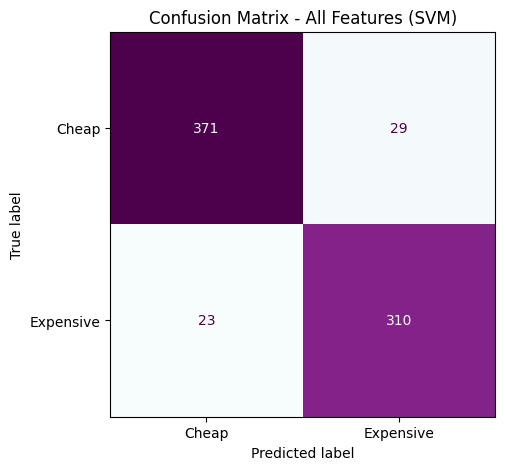


📊 Classification Report for KNN (All Features):
              precision    recall  f1-score   support

       Cheap       0.90      0.93      0.91       400
   Expensive       0.91      0.88      0.89       333

    accuracy                           0.91       733
   macro avg       0.91      0.90      0.90       733
weighted avg       0.91      0.91      0.91       733



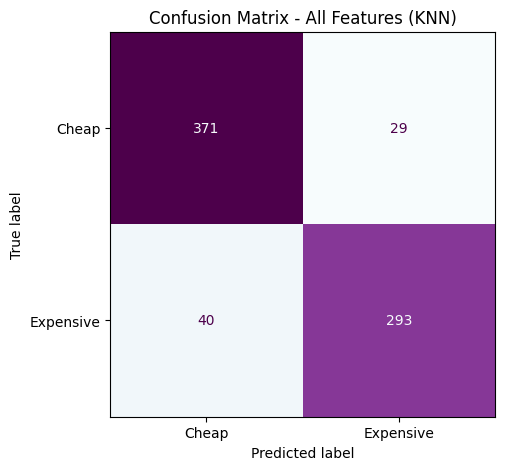


📊 Classification Report for Random Forest (All Features):
              precision    recall  f1-score   support

       Cheap       0.92      0.95      0.93       400
   Expensive       0.94      0.90      0.92       333

    accuracy                           0.93       733
   macro avg       0.93      0.93      0.93       733
weighted avg       0.93      0.93      0.93       733



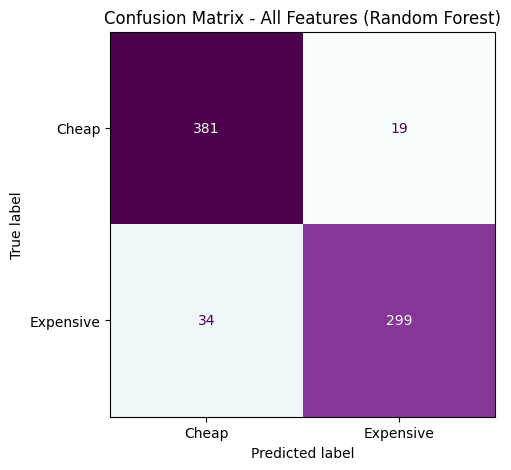


Debug - results_all structure:
{'SVM': {'accuracy': 0.9290586630286494, 'precision': 0.9144542772861357, 'recall': 0.9309309309309309, 'f1_score': 0.9226190476190477}, 'KNN': {'accuracy': 0.9058663028649386, 'precision': 0.9099378881987578, 'recall': 0.8798798798798799, 'f1_score': 0.8946564885496183}, 'Random Forest': {'accuracy': 0.927694406548431, 'precision': 0.940251572327044, 'recall': 0.8978978978978979, 'f1_score': 0.9185867895545314}}

✅ Formatted Results After All Features Evaluation:
                       Model  Accuracy  Precision    Recall  F1-score
SVM                      SVM  0.929059   0.914454  0.930931  0.922619
KNN                      KNN  0.905866   0.909938  0.879880  0.894656
Random Forest  Random Forest  0.927694   0.940252  0.897898  0.918587


In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\n🔍 Performance on All Features")
results_all = {}

for name, model in models.items():
    # Fit and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store metrics
    results_all[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

    # === Classification Report ===
    print(f"\n📊 Classification Report for {name} (All Features):")
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='BuPu', colorbar=False)
    plt.title(f"Confusion Matrix - All Features ({name})")
    plt.show()

# === Convert to DataFrame ===
print("\nDebug - results_all structure:")
print(results_all)

all_results_df = pd.DataFrame(results_all).T
required_columns = ['accuracy', 'precision', 'recall', 'f1_score']
all_results_df = all_results_df[required_columns]
all_results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-score']
all_results_df['Model'] = all_results_df.index
all_results_df = all_results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']]

print("\n✅ Formatted Results After All Features Evaluation:")
print(all_results_df)


🚀 Running Genetic Algorithm...
gen	nevals	avg     	max     	min     
0  	40    	0.900259	0.923949	0.866892
1  	28    	0.907781	0.923949	0.881528
2  	29    	0.913876	0.922482	0.897617
3  	27    	0.915243	0.926387	0.894699
4  	28    	0.919703	0.926387	0.909324
5  	29    	0.919009	0.926876	0.903464
6  	33    	0.916961	0.926876	0.882018
7  	28    	0.92202 	0.928822	0.908341
8  	32    	0.922776	0.930773	0.912247
9  	36    	0.924301	0.932233	0.913217
10 	29    	0.926411	0.932235	0.915658
11 	25    	0.92658 	0.93321 	0.913712
12 	24    	0.928078	0.93321 	0.906391
13 	30    	0.928796	0.93321 	0.918584
14 	30    	0.928942	0.93321 	0.910779
15 	26    	0.93015 	0.933693	0.916149
16 	30    	0.930138	0.933693	0.916632
17 	32    	0.930357	0.934184	0.918101
18 	31    	0.929845	0.935648	0.912245
19 	26    	0.930819	0.934182	0.911754
20 	30    	0.931757	0.935156	0.918101
21 	29    	0.930697	0.935156	0.911266
22 	24    	0.931928	0.934672	0.914682
23 	30    	0.930904	0.934672	0.898588
24 	26    	0.931587

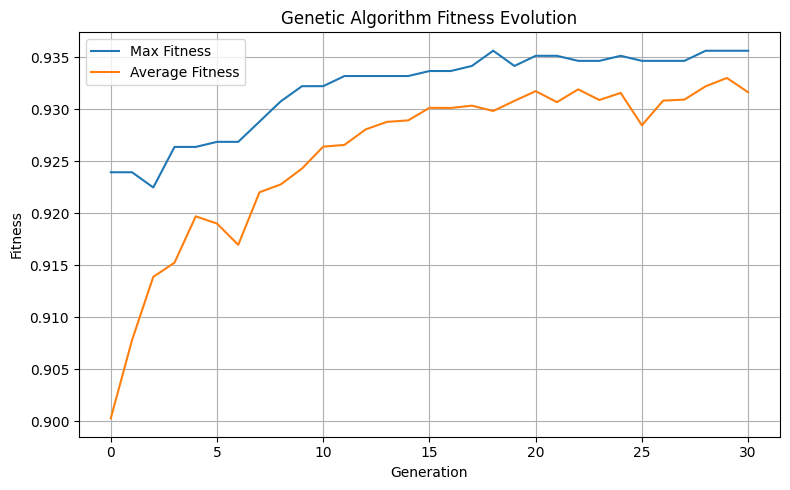

In [ ]:

from deap import base, creator, tools, algorithms
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler


# GA setup
N_FEATURES = X_train.shape[1]

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, N_FEATURES)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# GA fitness function with Stratified CV for better generalization
def evaluate_ga(individual):
    selected = [i for i, bit in enumerate(individual) if bit == 1]
    if not selected:
        return 0.0,
    X_sel = X_train[:, selected]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(SVC(kernel='linear', C=1), X_sel, y_train, cv=cv).mean()
    return score,

toolbox.register("evaluate", evaluate_ga)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=40)

stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

# Run Genetic Algorithm
print("\U0001F680 Running Genetic Algorithm...")
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.6, mutpb=0.3, ngen=30,
                                    stats=stats, verbose=True)

print("\n\U0001F9EC Final GA Population and Fitness Scores:")
for i, ind in enumerate(pop):
    print(f"Individual {i+1}: {ind}")
    print(f"  -> Fitness: {ind.fitness.values[0]:.4f}")

best_ind = tools.selBest(pop, 1)[0]
selected_ga = [i for i, bit in enumerate(best_ind) if bit == 1]
print("\n\U0001F3C5 Best Individual (GA):")
print(f"Binary Mask: {best_ind}")
print(f"Selected Feature Indices: {selected_ga}")
print(f"Number of Features Selected: {len(selected_ga)}")

gen = logbook.select("gen")
max_fitness = logbook.select("max")
avg_fitness = logbook.select("avg")

print("\n\U0001F4C8 Fitness Evolution by Generation:")
for g, max_f, avg_f in zip(gen, max_fitness, avg_fitness):
    print(f"Gen {g:2d} -> Max: {max_f:.4f}, Avg: {avg_f:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(gen, max_fitness, label="Max Fitness")
plt.plot(gen, avg_fitness, label="Average Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic Algorithm Fitness Evolution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
feature_mask_ga = pd.Series(best_ind, index=X.columns).astype(int)
feature_table_ga = pd.DataFrame({
    'Feature': X.columns,
    'Selected (GA)': feature_mask_ga.values
})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("\n📋 GA Feature Selection Table (Full View):")
print(feature_table_ga)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')




📋 GA Feature Selection Table (Full View):
            Feature  Selected (GA)
0             Order              0
1       MS SubClass              0
2         MS Zoning              1
3      Lot Frontage              0
4          Lot Area              1
5            Street              1
6         Lot Shape              0
7      Land Contour              0
8         Utilities              0
9        Lot Config              0
10       Land Slope              1
11     Neighborhood              0
12      Condition 1              0
13      Condition 2              0
14        Bldg Type              1
15      House Style              1
16     Overall Qual              1
17     Overall Cond              1
18       Year Built              1
19   Year Remod/Add              0
20       Roof Style              1
21        Roof Matl              0
22     Exterior 1st              1
23     Exterior 2nd              1
24     Mas Vnr Area              0
25       Exter Qual              0
26       Ext


🔍 Performance on GA-Selected Features

📊 Classification Report for SVM (GA-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.95      0.93      0.94       400
   Expensive       0.92      0.94      0.93       333

    accuracy                           0.93       733
   macro avg       0.93      0.93      0.93       733
weighted avg       0.93      0.93      0.93       733



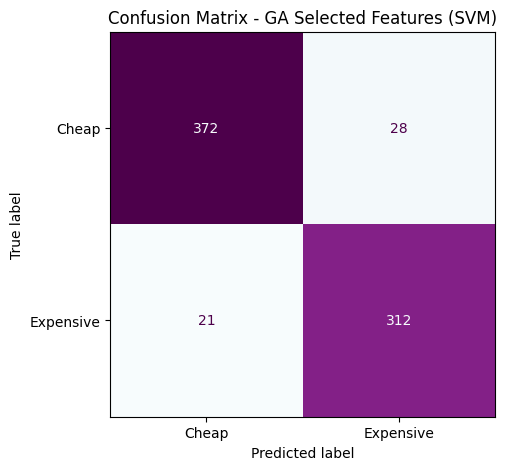


📊 Classification Report for KNN (GA-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.92      0.94      0.93       400
   Expensive       0.92      0.90      0.91       333

    accuracy                           0.92       733
   macro avg       0.92      0.92      0.92       733
weighted avg       0.92      0.92      0.92       733



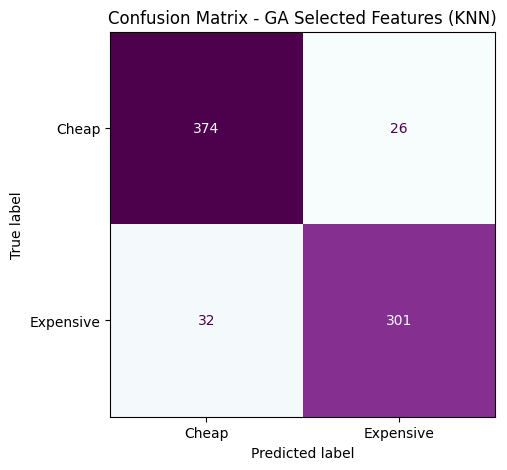


📊 Classification Report for Random Forest (GA-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.92      0.94      0.93       400
   Expensive       0.93      0.90      0.91       333

    accuracy                           0.92       733
   macro avg       0.92      0.92      0.92       733
weighted avg       0.92      0.92      0.92       733



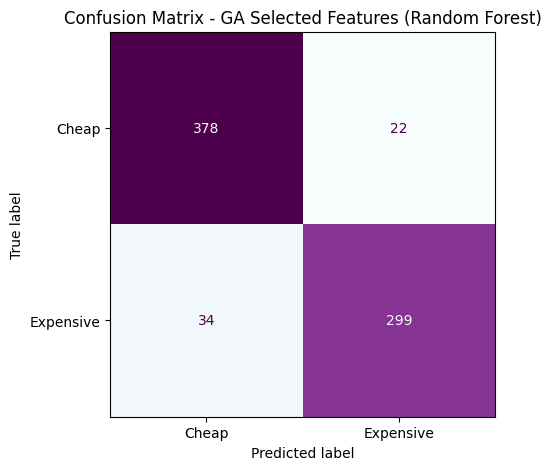


Debug - results_ga structure:
{'SVM': {'accuracy': 0.9331514324693042, 'precision': 0.9176470588235294, 'recall': 0.9369369369369369, 'f1_score': 0.9271916790490342}, 'KNN': {'accuracy': 0.9208731241473397, 'precision': 0.9204892966360856, 'recall': 0.9039039039039038, 'f1_score': 0.9121212121212121}, 'Random Forest': {'accuracy': 0.9236016371077762, 'precision': 0.9314641744548287, 'recall': 0.8978978978978979, 'f1_score': 0.9143730886850153}}

✅ Formatted Results After GA Evaluation:
                       Model  Accuracy  Precision    Recall  F1-score
SVM                      SVM  0.933151   0.917647  0.936937  0.927192
KNN                      KNN  0.920873   0.920489  0.903904  0.912121
Random Forest  Random Forest  0.923602   0.931464  0.897898  0.914373


In [ ]:


print("\n🔍 Performance on GA-Selected Features")
results_ga = {}

for name, model in models.items():
    # Fit and predict using GA-selected features
    model.fit(X_train[:, selected_ga], y_train)
    y_pred = model.predict(X_test[:, selected_ga])

    # Store metrics
    results_ga[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

    # === Classification Report ===
    print(f"\n📊 Classification Report for {name} (GA-Selected Features):")
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='BuPu', colorbar=False)
    plt.title(f"Confusion Matrix - GA Selected Features ({name})")
    plt.show()

# === Convert to DataFrame ===
print("\nDebug - results_ga structure:")
print(results_ga)

ga_results_df = pd.DataFrame(results_ga).T
required_columns = ['accuracy', 'precision', 'recall', 'f1_score']
ga_results_df = ga_results_df[required_columns]
ga_results_df.columns = ['Accuracy', 'Precision', 'Recall', 'F1-score']
ga_results_df['Model'] = ga_results_df.index
ga_results_df = ga_results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']]

print("\n✅ Formatted Results After GA Evaluation:")
print(ga_results_df)


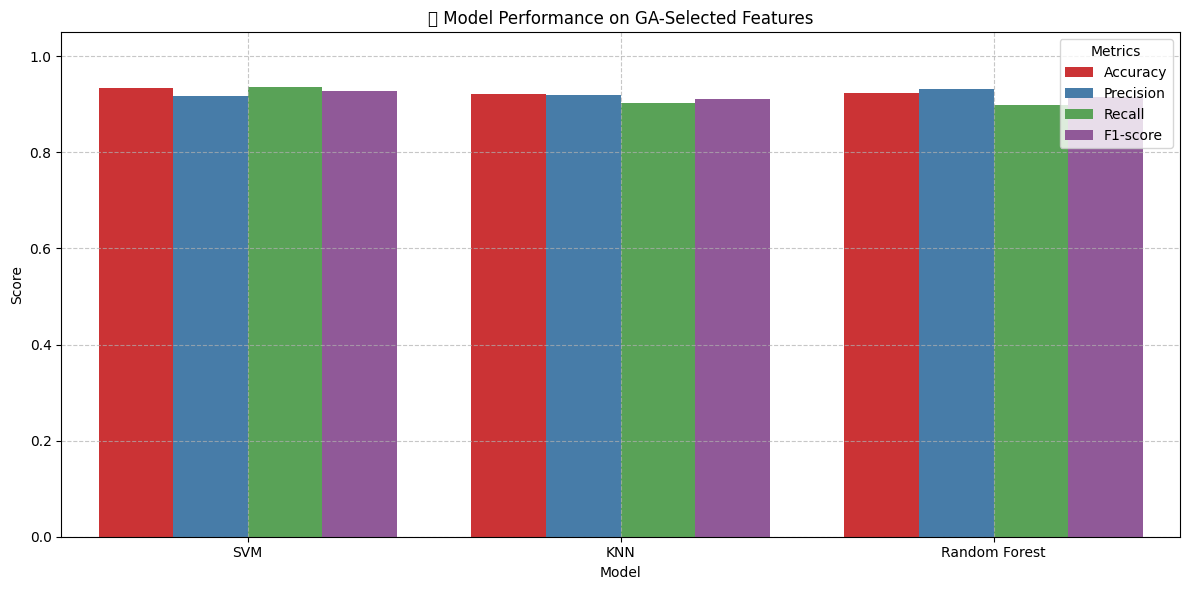

In [ ]:

# --- Visualization of GA Evaluation Results ---
ga_results_melted = ga_results_df.melt(id_vars='Model',
                                       value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'],
                                       var_name='Metric', value_name='Score')

# Plotting the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=ga_results_melted, x='Model', y='Score', hue='Metric', ci=None, palette='Set1')

plt.title('📊 Model Performance on GA-Selected Features')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Metrics')
plt.show()

In [ ]:
!pip install pyswarms


2025-05-18 17:03:10,296 - pyswarms.single.global_best - INFO - Optimize for 30 iters with {'c1': 2, 'c2': 2, 'w': 0.9}


Running Particle Swarm Optimization...


pyswarms.single.global_best: 100%|██████████|30/30, best_cost=-0.939
2025-05-18 17:13:51,894 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9390101470283702, best pos: [ -0.75512351  -2.23085518   3.43594787   0.84746105   2.15472258
   1.76028492 -14.91526863   5.69012145   1.21237715   2.27847167
   0.26020256   0.48197794  12.57805783   4.00171435   3.56030552
   1.44318741   3.62861931   5.59669007   2.00482726  13.96779426
  -0.46406719   0.75389535   0.60167941 -27.8277102  -20.91885514
  -3.03787804   4.96597345  -1.11013143   1.2381996  -19.00637199
   1.35747681  -3.03858419   3.41572389   2.19895803   8.58738082
   3.67282942   0.5997221    0.94508868   5.69679675   1.40202271
  12.1940014    1.99273036   1.19815238   2.20647271   1.92476292
   0.92620221   2.47624057   8.20164414  -0.35954737   1.46311254
   0.4156888   10.79984408   2.02708538   1.35824215   3.31977842
   2.05432358   2.76608731   0.75661031   7.41574947   4.86731766
  -3.29383


 Best Particle (PSO):
Binary Mask: [0 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1]
Selected Feature Indices: [ 2  3  4  5  7  8  9 12 13 14 15 16 17 18 19 21 22 26 28 30 32 33 34 35
 36 37 38 39 40 41 42 43 44 45 46 47 49 51 52 53 54 55 56 57 58 59 61 62
 63 65 66 67 68 69 70 71]
Number of Features Selected: 56


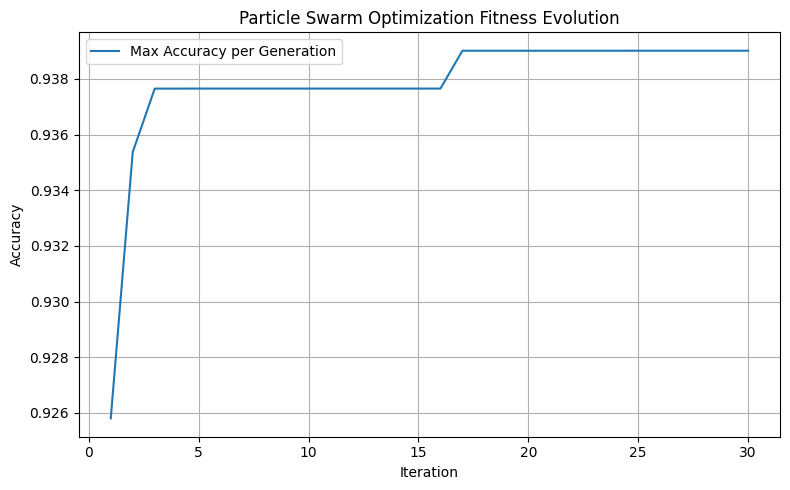

In [ ]:
from pyswarms.single import GlobalBestPSO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

def pso_objective(weights):
    binary_weights = weights > 0.5
    scores = []
    for particle in binary_weights:
        if np.sum(particle) == 0:
            scores.append(0)
        else:
            X_sel = X_train[:, particle]
            clf = SVC(kernel='linear', C=1)
            acc = cross_val_score(clf, X_sel, y_train, cv=5).mean()
            scores.append(-acc)
    return np.array(scores)

n_particles = 30
n_iterations = 30
options = {'c1': 2, 'c2': 2, 'w': 0.9}

# --- Run PSO ---
print("Running Particle Swarm Optimization...")
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=X_train.shape[1], options=options)
cost, pos = optimizer.optimize(pso_objective, iters=n_iterations)

binary_pos = pos > 0.5
selected_pso = np.where(binary_pos)[0]

print("\n Best Particle (PSO):")
print(f"Binary Mask: {binary_pos.astype(int)}")
print(f"Selected Feature Indices: {selected_pso}")
print(f"Number of Features Selected: {len(selected_pso)}")

cost_history = optimizer.cost_history

plt.figure(figsize=(8, 5))
plt.plot(range(1, n_iterations + 1), -np.array(cost_history), label='Max Accuracy per Generation')
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Particle Swarm Optimization Fitness Evolution")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

feature_mask_pso = pd.Series(binary_pos, index=X.columns).astype(int)
feature_table_pso = pd.DataFrame({
    'Feature': X.columns,
    'Selected (PSO)': feature_mask_pso.values
})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

print("\n📋 PSO Feature Selection Table (Full View):")
print(feature_table_pso)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')



📋 PSO Feature Selection Table (Full View):
            Feature  Selected (PSO)
0             Order               0
1       MS SubClass               0
2         MS Zoning               1
3      Lot Frontage               1
4          Lot Area               1
5            Street               1
6         Lot Shape               0
7      Land Contour               1
8         Utilities               1
9        Lot Config               1
10       Land Slope               0
11     Neighborhood               0
12      Condition 1               1
13      Condition 2               1
14        Bldg Type               1
15      House Style               1
16     Overall Qual               1
17     Overall Cond               1
18       Year Built               1
19   Year Remod/Add               1
20       Roof Style               0
21        Roof Matl               1
22     Exterior 1st               1
23     Exterior 2nd               0
24     Mas Vnr Area               0
25       Exter Qual 


🔍 Performance on PSO-Selected Features

📊 Classification Report for SVM (PSO-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.94      0.92      0.93       400
   Expensive       0.91      0.92      0.92       333

    accuracy                           0.92       733
   macro avg       0.92      0.92      0.92       733
weighted avg       0.92      0.92      0.92       733



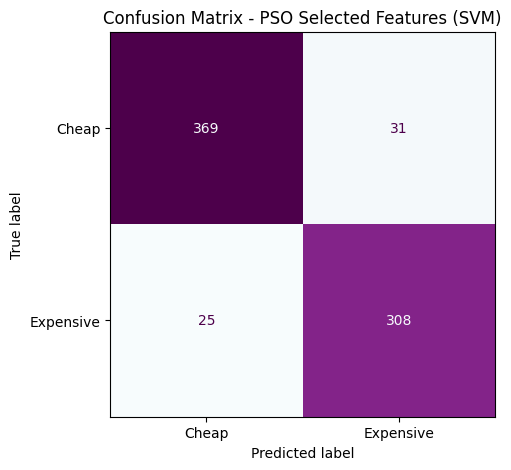


📊 Classification Report for KNN (PSO-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.90      0.92      0.91       400
   Expensive       0.90      0.88      0.89       333

    accuracy                           0.90       733
   macro avg       0.90      0.90      0.90       733
weighted avg       0.90      0.90      0.90       733



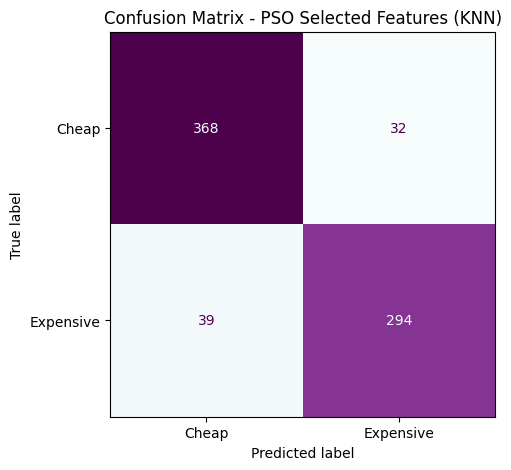


📊 Classification Report for Random Forest (PSO-Selected Features):
              precision    recall  f1-score   support

       Cheap       0.92      0.95      0.94       400
   Expensive       0.94      0.90      0.92       333

    accuracy                           0.93       733
   macro avg       0.93      0.93      0.93       733
weighted avg       0.93      0.93      0.93       733



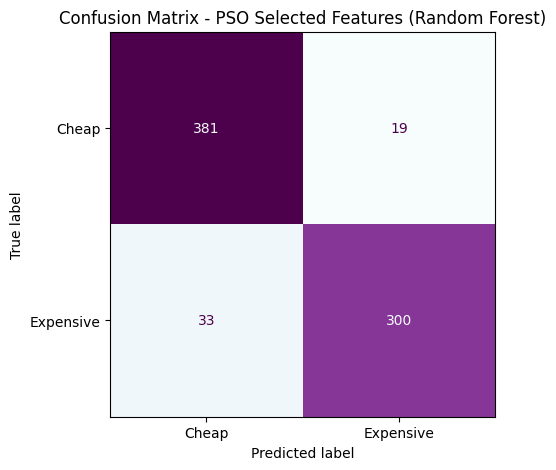


✅ Formatted Results After PSO Evaluation:
                       Model  Accuracy  Precision    Recall  F1-score
SVM                      SVM  0.923602   0.908555  0.924925  0.916667
KNN                      KNN  0.903138   0.901840  0.882883  0.892261
Random Forest  Random Forest  0.929059   0.940439  0.900901  0.920245


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\n🔍 Performance on PSO-Selected Features")
results_pso = {}

for name, model in models.items():
    # Fit and predict using PSO-selected features
    model.fit(X_train[:, selected_pso], y_train)
    y_pred = model.predict(X_test[:, selected_pso])

    # Store metrics
    results_pso[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }

    # === Classification Report ===
    print(f"\n📊 Classification Report for {name} (PSO-Selected Features):")
    print(classification_report(y_test, y_pred, target_names=list(classes.values())))

    # === Confusion Matrix ===
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(classes.values()))
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap='BuPu', colorbar=False)
    plt.title(f"Confusion Matrix - PSO Selected Features ({name})")
    plt.show()

# === Convert to DataFrame ===
pso_results_df = pd.DataFrame(results_pso).T
pso_results_df['Model'] = pso_results_df.index
pso_results_df = pso_results_df[['Model', 'accuracy', 'precision', 'recall', 'f1_score']]
pso_results_df.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score']

print("\n✅ Formatted Results After PSO Evaluation:")
print(pso_results_df)


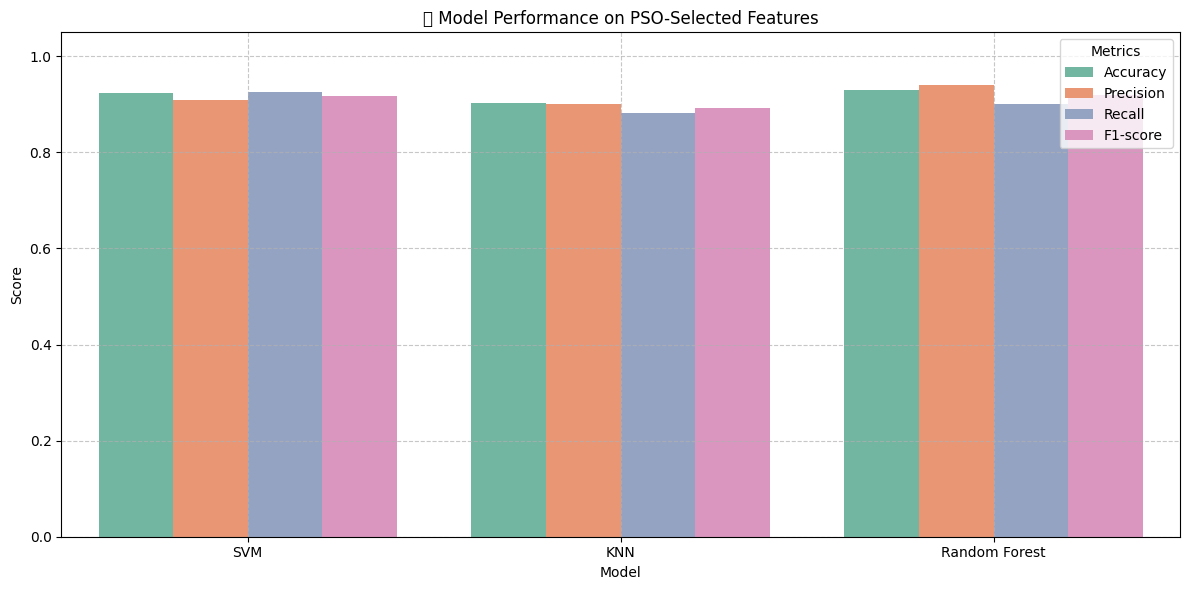

In [ ]:
# --- Visualization of PSO Evaluation Results ---
pso_results_melted = pso_results_df.melt(id_vars='Model',
                                         value_vars=['Accuracy', 'Precision', 'Recall', 'F1-score'], # Changed to uppercase
                                         var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 6))
sns.barplot(data=pso_results_melted, x='Model', y='Score', hue='Metric', ci=None, palette='Set2')

plt.title('📊 Model Performance on PSO-Selected Features')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Metrics')
plt.show()


 Final Comparison of Model Performance Across Feature Sets:
           Model  accuracy  precision    recall  f1_score   Feature Set
0            SVM  0.929059   0.914454  0.930931  0.922619  All Features
1            KNN  0.905866   0.909938  0.879880  0.894656  All Features
2  Random Forest  0.927694   0.940252  0.897898  0.918587  All Features
3            SVM  0.933151   0.917647  0.936937  0.927192   GA Selected
4            KNN  0.920873   0.920489  0.903904  0.912121   GA Selected
5  Random Forest  0.923602   0.931464  0.897898  0.914373   GA Selected
6            SVM  0.923602   0.908555  0.924925  0.916667  PSO Selected
7            KNN  0.903138   0.901840  0.882883  0.892261  PSO Selected
8  Random Forest  0.929059   0.940439  0.900901  0.920245  PSO Selected


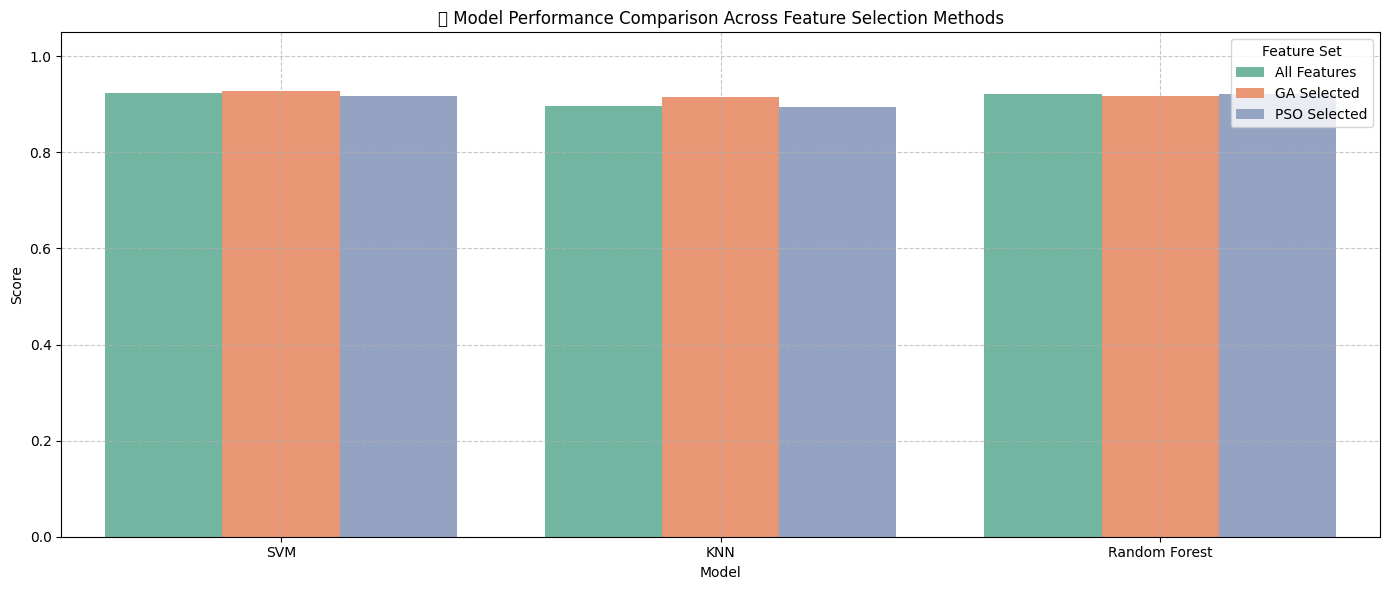

In [ ]:
# === Combine and Compare Results ===
df_all = pd.DataFrame(results_all).T
df_all['Feature Set'] = 'All Features'

df_ga = pd.DataFrame(results_ga).T
df_ga['Feature Set'] = 'GA Selected'

df_pso = pd.DataFrame(results_pso).T
df_pso['Feature Set'] = 'PSO Selected'
results_df = pd.concat([df_all, df_ga, df_pso])
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model'}, inplace=True)

print("\n Final Comparison of Model Performance Across Feature Sets:")
print(results_df)

# === Visualization of Results ===
results_melted = results_df.melt(
    id_vars=['Model', 'Feature Set'],
    value_vars=['accuracy', 'precision', 'recall', 'f1_score'],
    var_name='Metric',
    value_name='Score'
)


plt.figure(figsize=(14, 6))
sns.barplot(data=results_melted, x='Model', y='Score', hue='Feature Set', ci=None, palette='Set2')
plt.title('📈 Model Performance Comparison Across Feature Selection Methods')
plt.ylabel('Score')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.legend(title='Feature Set')
plt.show()


In [ ]:
def predict_sample_with_models(models, sample, feature_names, selected_mask, label_map, set_name):
    print(f"\n{'='*40}\n🔍 Predictions using {set_name}\n{'='*40}")

    # Prepare input based on feature selection
    selected_features = feature_names[selected_mask] if isinstance(selected_mask, (list, np.ndarray)) else feature_names
    input_vector = sample[selected_features].values.reshape(1, -1)

    for model_name, model in models.items():
        pred = model.predict(input_vector)[0]
        print(f"🔹 {model_name}: {label_map[pred]}")


In [ ]:
# Example new sample
new_sample_dict = {
    'MS SubClass': 20,
    'MS Zoning': 1,
    'Lot Frontage': 80,
    'Lot Area': 9600,
    'Street': 1,
    'Lot Shape': 0,
    'Land Contour': 0,
    'Utilities': 0,
    'Lot Config': 1,
    'Land Slope': 0,
    'Neighborhood': 5,
    'Condition 1': 0,
    'Condition 2': 0,
    'Bldg Type': 0,
    'House Style': 1,
    'Overall Qual': 7,
    'Overall Cond': 5,
    'Year Built': 2003,
    'Year Remod/Add': 2003,
    'Roof Style': 1,
    'Roof Matl': 0,
    'Exterior 1st': 2,
    'Exterior 2nd': 2,
    'Mas Vnr Area': 196,
    'Exter Qual': 2,
    'Exter Cond': 1,
    'Foundation': 2,
    'Bsmt Qual': 3,
    'Bsmt Cond': 1,
    'Bsmt Exposure': 0,
    'BsmtFin Type 1': 2,
    'BsmtFin SF 1': 706,
    'BsmtFin Type 2': 1,
    'BsmtFin SF 2': 0,
    'Bsmt Unf SF': 150,
    'Total Bsmt SF': 856,
    'Heating': 1,
    'Heating QC': 4,
    'Central Air': 1,
    'Electrical': 1,
    '1st Flr SF': 856,
    '2nd Flr SF': 854,
    'Low Qual Fin SF': 0,
    'Gr Liv Area': 1710,
    'Bsmt Full Bath': 1,
    'Bsmt Half Bath': 0,
    'Full Bath': 2,
    'Half Bath': 1,
    'Bedroom AbvGr': 3,
    'Kitchen AbvGr': 1,
    'Kitchen Qual': 3,
    'TotRms AbvGrd': 7,
    'Functional': 0,
    'Fireplaces': 1,
    'Fireplace Qu': 1,
    'Garage Type': 2,
    'Garage Yr Blt': 2003,
    'Garage Finish': 1,
    'Garage Cars': 2,
    'Garage Area': 548,
    'Garage Qual': 1,
    'Garage Cond': 1,
    'Paved Drive': 1,
    'Wood Deck SF': 200,
    'Open Porch SF': 60,
    'Enclosed Porch': 0,
    '3Ssn Porch': 0,
    'Screen Porch': 120,
    'Pool Area': 0,
    'Misc Val': 0,
    'Mo Sold': 6,
    'Yr Sold': 2009,
    'Sale Type': 0,
    'Sale Condition': 0
}

new_sample_df = pd.DataFrame([new_sample_dict])



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

def predict_all_models(new_sample_df, scaler, models, selected_ga, selected_pso, X_train, y_train):
    predictions = {}
    original_feature_cols = X.columns # Assuming X is the DataFrame before train/test split

    if not new_sample_df.columns.equals(X.columns):
         # This is a robust way to ensure column alignment
        new_sample_df = new_sample_df.reindex(columns=X.columns, fill_value=0) # Fill missing with 0, adjust if needed
    new_sample_scaled = scaler.transform(new_sample_df)


    # All features
    for name, model in models.items():
        model.fit(X_train, y_train)
        # Predict on the scaled new sample data (all features)
        pred = model.predict(new_sample_scaled)[0]
        predictions[f"{name} (All)"] = int(pred)
    new_sample_ga_scaled = new_sample_scaled[:, selected_ga]
    for name, model in models.items():
        # Re-train on GA-selected *scaled* training data
        model.fit(X_train[:, selected_ga], y_train)
        # Predict on the GA-selected *scaled* new sample data
        pred = model.predict(new_sample_ga_scaled)[0]
        predictions[f"{name} (GA)"] = int(pred)
    new_sample_pso_scaled = new_sample_scaled[:, selected_pso]
    for name, model in models.items():
        model.fit(X_train[:, selected_pso], y_train)
        pred = model.predict(new_sample_pso_scaled)[0]
        predictions[f"{name} (PSO)"] = int(pred)


    return predictions

In [ ]:

predictions = predict_all_models(new_sample_df, scaler, models, selected_ga, selected_pso, X_train, y_train)
print("\n📈 Predictions on New Sample:")
label_map = classes
for model_name, pred_int in predictions.items():
    pred_label = label_map.get(pred_int, f"Unknown ({pred_int})")
    print(f"{model_name}: {pred_label}")


📈 Predictions on New Sample:
SVM (All): Expensive
KNN (All): Cheap
Random Forest (All): Expensive
SVM (GA): Expensive
KNN (GA): Cheap
Random Forest (GA): Expensive
SVM (PSO): Expensive
KNN (PSO): Cheap
Random Forest (PSO): Expensive
